In [385]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import random
import functions
import hybrid_ann
import matplotlib.pyplot as plt
from RBF import RBF
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
import seaborn as sns
sns.set()
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 16, 8

In [230]:
df = pd.read_csv('beer.csv')
data = df.iloc[:, -1].values

ent = 8

serie_normal = functions.normalizar_serie(data)
serie_lags = functions.gerar_janelas(tam_janela = ent, serie = serie_normal)
X_train, y_train, X_test, y_test = functions.split_serie_with_lags(serie = serie_lags, perc_train = 0.8, perc_val = 0)

In [232]:
mse = np.Inf
for i in range(5):
    model = hybrid_ann.LNL_ANN(m = ent)
    model.fit_MPSO(X = X_train, y = y_train, d= 30, c1i = 1.0, c1f = 2.0, c2i = 1.0, c2f = 2.0, w1 = 0.5, w2 = 1.0, maxt = 1000)
    if mean_squared_error(y_test, model.predict(X_test)) < mse:
        mse = mean_squared_error(y_test, model.predict(X_test))
        best_model = model
        print('MSE:',mean_squared_error(y_test, best_model.predict(X_test)))

MSE: 1.055493483867781
MSE: 0.023429339377689908
MSE: 0.009641083726656365


In [236]:
model = best_model

# Análise de Dados

## Conjunto de treinamento

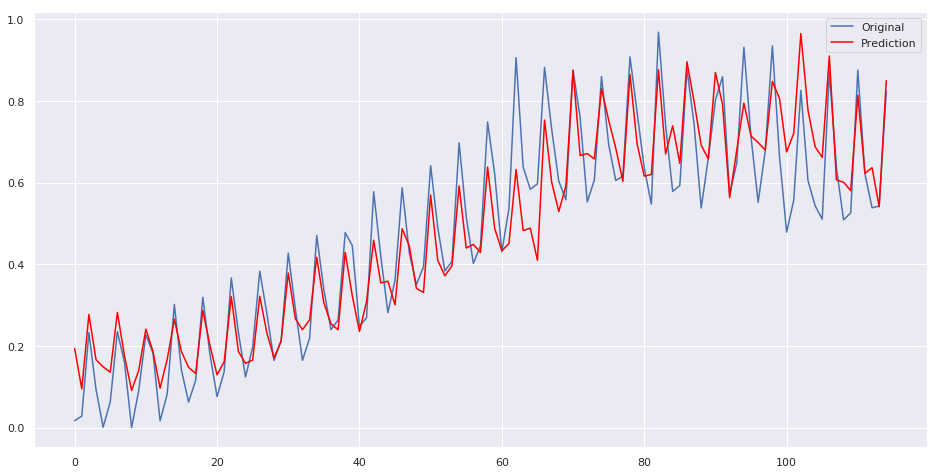

In [386]:
y_train_pred = model.predict(X_train)
plt.plot(y_train, label = 'Original')
plt.plot(y_train_pred, label = 'Prediction', color = 'red')
plt.legend()

## Test Data

In [238]:
y_test_ = functions.desnormalizar(y_test, data).iloc[:,0].values
y_pred_ = functions.desnormalizar(y_pred, data).iloc[:,0].values

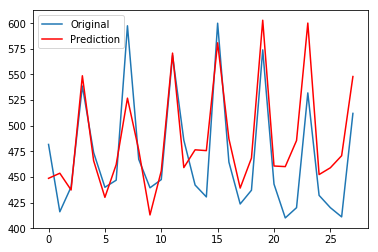

In [239]:
plt.plot(y_test_, label = 'Original')
plt.plot(y_pred_, label = 'Prediction', color = 'red')
plt.legend()

# Erro da série

In [240]:
resid_train = functions._error(y_train, y_train_pred)
resid_test = functions._error(y_test, y_pred)

In [241]:
tam_jan = 2
resid_train_lags = functions.gerar_janelas(tam_janela = tam_jan, serie = resid_train)
resid_test_lags = functions.gerar_janelas(tam_janela = tam_jan, serie = resid_test)

In [242]:
#Treinamento
X_error_train = resid_train_lags[:, :-1]
y_error_train = resid_train_lags[:, -1]

#Teste
X_error_test = resid_test_lags[:, :-1]
y_error_test = resid_test_lags[:, -1]

# Modelo Proposto 1:

<img src="model1.png">

In [243]:
mse = np.Inf
for i in range(5):
    model_resid = hybrid_ann.LNL_ANN(m = tam_jan)
    model_resid.fit_MPSO(X = X_error_train, y = y_error_train, d= 40, c1i = 1.0, c1f = 2.0, c2i = 1.0, c2f = 2.0, w1 = 0.2, w2 = 0.8, maxt = 2000)
    if mean_squared_error(y_error_test, model_resid.predict(X_error_test)) < mse:
        mse = mean_squared_error(y_error_test, model_resid.predict(X_error_test))
        best_model = model_resid
        print('MSE:', mse)

MSE: 0.007976956299394062
MSE: 0.006628903176765534


In [248]:
model_resid = best_model

In [249]:
resid_pred = model_resid.predict(X_error_test)
resid_pred_ = functions.desnormalizar(y_pred[tam_jan+1:] + resid_pred,data).iloc[:,0].values

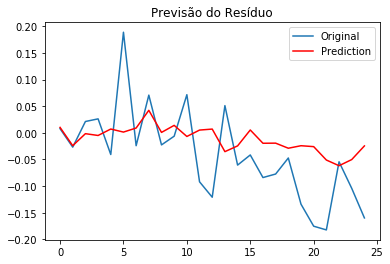

In [250]:
plt.plot(y_error_test, label = 'Original')
plt.plot(resid_pred, label = 'Prediction', color = 'red')
plt.title('Previsão do Resíduo')
plt.legend()

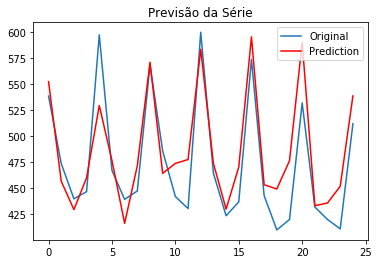

In [251]:
plt.plot(y_test_[tam_jan+1:], label = 'Original')
plt.plot(resid_pred_, label = 'Prediction', color = 'red')
plt.title('Previsão da Série')
plt.legend()

# Modelo Proposto 2:

<img src="model2.png">

In [541]:
X_train_e = np.hstack((X_train[1:, :], resid_train[:-1].reshape(-1, 1)))
X_test_e = np.hstack((X_test[1:, :], resid_test[:-1].reshape(-1,1)))

In [542]:
mse = np.Inf
for i in range(5):
    model2 = hybrid_ann.Hybrid_ANN(model.weight)
    model2.fit_MPSO(X = X_train_e, y = y_train[1:], d= 40, c1i = 0.5, c1f = 1.5, c2i = 0.5, c2f = 1.5, w1 = 0.2, w2 = 0.8, maxt = 2000)
    if mean_squared_error(y_test[1:], model2.predict(X_test_e)) < mse:
        mse = mean_squared_error(y_test[1:], model2.predict(X_test_e))
        best_model = model2
        print('MSE:', mse)

MSE: 0.008107519634363389


In [543]:
model2 = best_model

In [544]:
y_pred2 = model2.predict(X_test_e)
y_pred2_ = functions.desnormalizar(y_pred2, data).iloc[:,0].values

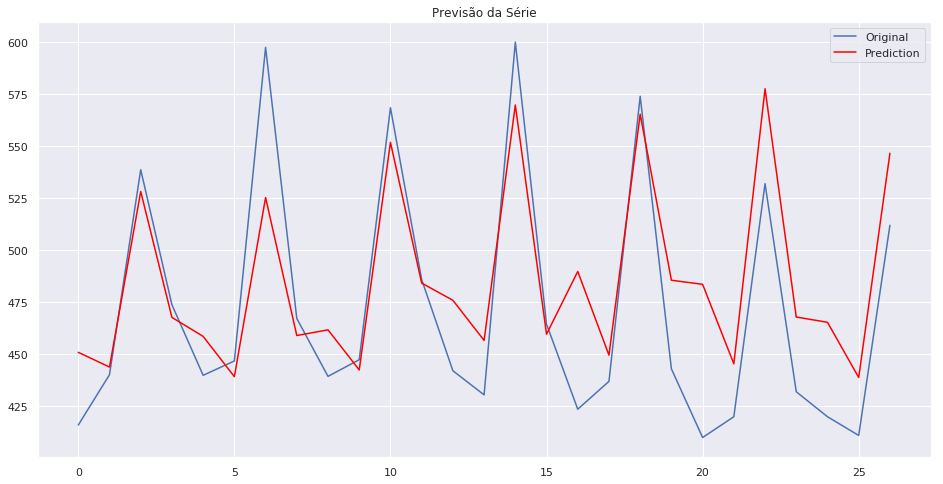

In [545]:
plt.plot(functions.desnormalizar(y_test[1:],data), label = 'Original')
plt.plot(y_pred2_ , label = 'Prediction', color = 'red')
plt.title('Previsão da Série')
plt.legend()

## Comparação entre os modelos

### RBF

In [413]:
rbf = RBF(8, 32, 1)
rbf.train(X_train, y_train)
z = rbf.test(X_test)
z_ = functions.desnormalizar(z, data).iloc[:,0].values

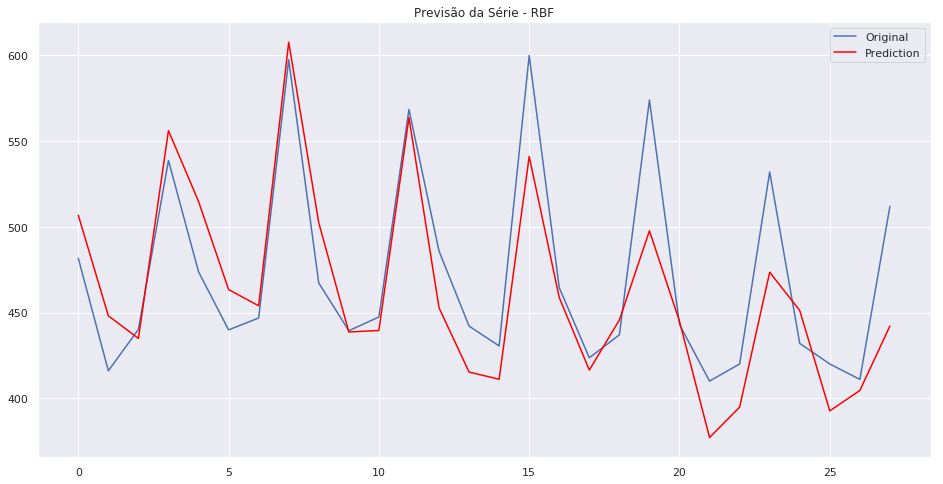

In [414]:
plt.plot(y_test_, label = 'Original')
plt.plot(z_ , label = 'Prediction', color = 'red')
plt.title('Previsão da Série - RBF')
plt.legend()

### FFANN

In [453]:
ffann = MLPRegressor(hidden_layer_sizes=(20,),activation= 'tanh',solver='adam', max_iter=1000)
ffann.fit(X_train, y_train)
ffann_pred = ffann.predict(X_test)
ffann_ = functions.desnormalizar(ffann_pred, data).iloc[:,0].values

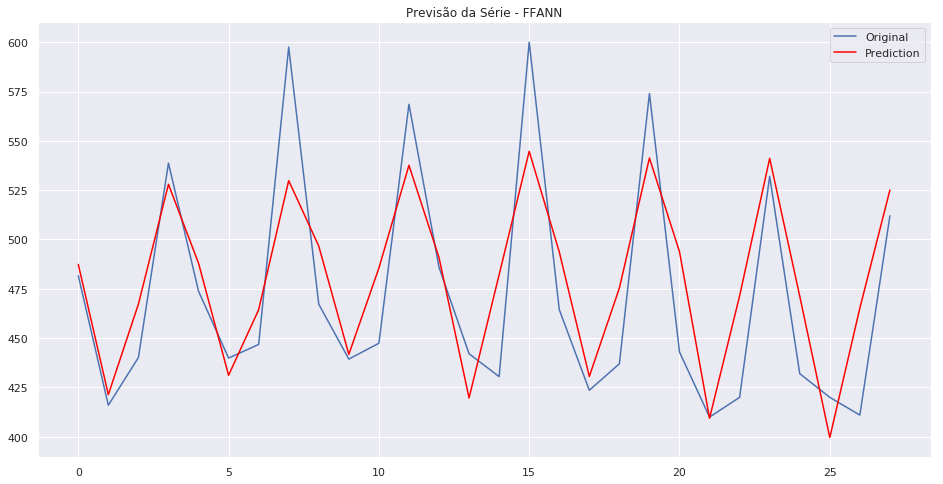

In [454]:
plt.plot(y_test_, label = 'Original')
plt.plot(ffann_ , label = 'Prediction', color = 'red')
plt.title('Previsão da Série - FFANN')
plt.legend()

### WMES

In [539]:
fit2 = ExponentialSmoothing(data[:-len(y_test_)-2], seasonal_periods = 4, trend='add', seasonal='mul').fit(use_boxcox=True)
wmes = fit2.forecast(len(y_test_))

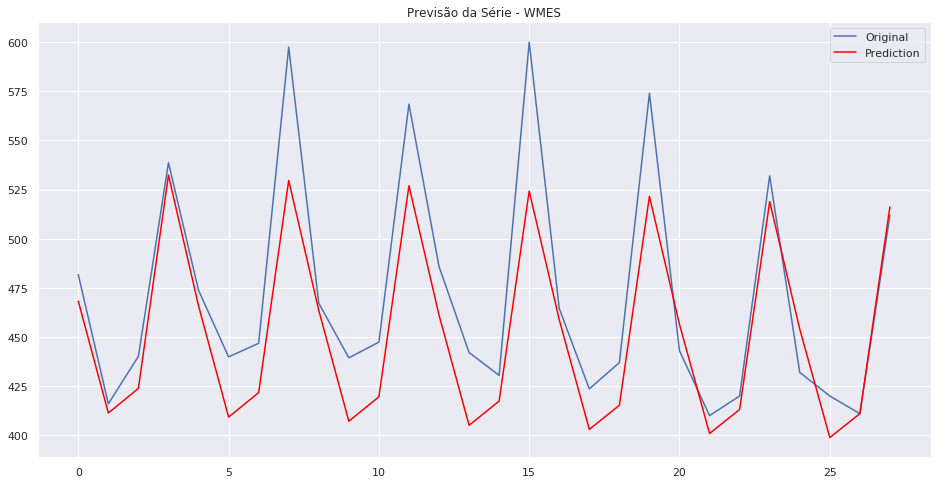

In [540]:
plt.plot(y_test_, label = 'Original')
plt.plot(wmes , label = 'Prediction', color = 'red')
plt.title('Previsão da Série - WMES')
plt.legend()

### SARIMA

In [576]:
ref = len(data) - len(y_test_)
mod = sm.tsa.statespace.SARIMAX(data[:ref], trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
res = mod.fit()
sarima = res.predict(start = ref, end= len(data)-1 , dynamic= True) 

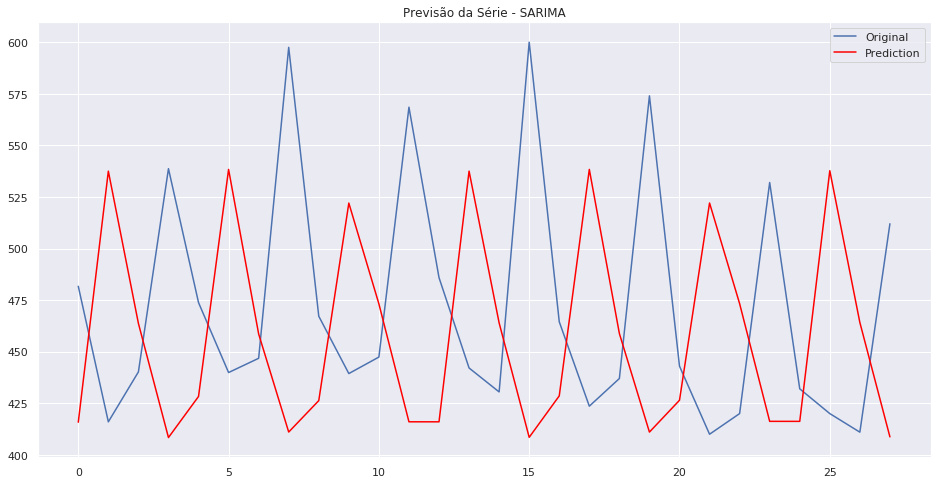

In [577]:
plt.plot(y_test_, label = 'Original')
plt.plot(sarima , label = 'Prediction', color = 'red')
plt.title('Previsão da Série - SARIMA')
plt.legend()

# Resultados

In [529]:
Forecasts = pd.DataFrame(
{
'Test data': y_test_,
'SARIMA': sarima,
'WMES': wmes,
'FFANN': ffann_,
'RBF': z_,
'L&NL-ANN': y_pred_
}
)

Metrics = pd.DataFrame(
{
'SARIMA': [functions.RMSE(y_test_, sarima), functions.MAPE(y_test_, sarima), functions.MdAPE(y_test_, sarima), functions.DA(y_test_, sarima)],
'WMES': [functions.RMSE(y_test_, wmes), functions.MAPE(y_test_, wmes), functions.MdAPE(y_test_, wmes), functions.DA(y_test_, wmes)],
'FFANN': [functions.RMSE(y_test_, ffann_), functions.MAPE(y_test_, ffann_), functions.MdAPE(y_test_, ffann_), functions.DA(y_test_, ffann_)],
'RBF': [functions.RMSE(y_test_, z_), functions.MAPE(y_test_, z_), functions.MdAPE(y_test_, z_), functions.DA(y_test_, z_)],
'L&NL-ANN': [functions.RMSE(y_test_, y_pred_), functions.MAPE(y_test_, y_pred_), functions.MdAPE(y_test_, y_pred_), functions.DA(y_test_, y_pred_)],
}, index = ['RMSE', 'MAPE', 'MdAPE', 'DA']
)

#Falta criar os outros modelos e inserir os respectivos conjuntos de previsão em cada função de erro.

In [530]:
Forecasts

,Test data,SARIMA,WMES,FFANN,RBF,L&NL-ANN
0,481.7,485.825306,468.273510,487.386051,506.829036,448.629112
1,416.0,434.219740,411.330842,421.391646,448.096865,453.614331
2,440.2,433.958605,423.859861,467.250788,434.917701,437.264867
3,538.7,555.570203,532.394206,527.974940,556.129075,548.731925
4,473.8,481.865271,465.901421,488.011371,514.853334,465.834585
5,439.9,426.714116,409.246914,431.176506,463.407233,430.080711
6,446.8,446.363625,421.709853,464.386658,453.946101,462.002277
7,597.5,556.563733,529.687081,529.846036,607.731735,526.878297
8,467.2,476.868690,463.531924,496.667449,502.384531,476.225540
9,439.4,429.678551,407.165264,441.777165,438.670499,412.914768


In [532]:
Metrics

,SARIMA,WMES,FFANN,RBF,L&NL-ANN
RMSE,26.410763,28.838331,32.424379,31.925952,34.988388
MAPE,0.043760,0.044879,0.055945,0.050719,0.062745
MdAPE,0.030646,0.042865,0.052500,0.048624,0.052735
DA,0.925926,0.888889,0.925926,0.962963,0.851852


In [379]:
Metrics2 = pd.DataFrame(
{
'RMSE': [functions.RMSE(y_test_, y_pred_), functions.RMSE(y_test_[3:], resid_pred_), functions.RMSE(y_test_[1:], y_pred2_)],
'MAPE': [functions.MAPE(y_test_, y_pred_), functions.MAPE(y_test_[3:], resid_pred_),functions.MAPE(y_test_[1:], y_pred2_)],
'MdAPE': [functions.MdAPE(y_test_, y_pred_), functions.MdAPE(y_test_[3:], resid_pred_),functions.MdAPE(y_test_[1:], y_pred2_)],
'DA': [functions.DA(y_test_, y_pred_), functions.DA(y_test_[3:], resid_pred_),functions.DA(y_test_[1:], y_pred2_)]
}, index = ['L&NL-ANN', 'L&NL-ANN Modified 1', 'L&NL-ANN Modified 2']
)

Metrics2

,RMSE,MAPE,MdAPE,DA
L&NL-ANN,34.988388,0.062745,0.052735,0.851852
L&NL-ANN Modified 1,30.459581,0.052792,0.037814,0.833333
L&NL-ANN Modified 2,33.973751,0.058840,0.051338,0.769231


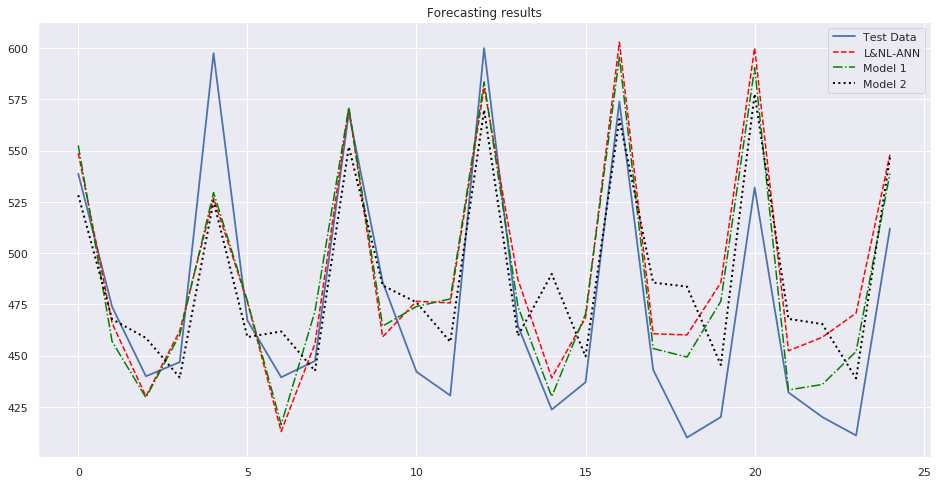

In [567]:
plt.plot(y_test_[tam_jan+1:], label = 'Test Data', linewidth=1.8)
plt.plot(y_pred_[tam_jan+1:], label = 'L&NL-ANN', color = 'red', linestyle='--')
plt.plot(resid_pred_, label = 'Model 1', linestyle='-.', color = 'green')
plt.plot(y_pred2_[tam_jan:] , label = 'Model 2', linestyle=':', color = 'black', linewidth=2)
plt.legend()
plt.title('Forecasting results')
plt.show()